<a href="https://colab.research.google.com/github/ellemimi/HelloWorld/blob/main/8%EC%9E%A5%EC%8A%A4%ED%84%B0%EB%94%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#먼저 필요한 라이브러리를 호출

import torch 
import matplotlib.pyplot as plt 
import numpy as np 

import torchvision 
import torchvision.transforms as transforms 

import torch.nn as nn 
import torch.optim as optim

In [8]:
#예제에서 사용할 FashionMNIST 데이터셋 내려받기 

trainset = torchvision.datasets.FashionMNIST( root='../chap08/data/', train= True, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../chap08/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap08/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../chap08/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap08/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../chap08/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap08/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../chap08/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap08/data/FashionMNIST/raw



In [9]:
#내려받은 데이터셋을 메모리로 가져오기
#단 trainloader 변수가 호출될 때 메모리로 가져옴

batch_size = 4 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) 

#batch_size를 4로 설정했기 때문에 데이터를 메모리로 가져 올 때 한 번에 네 개씩 쪼개서 가져옵니다. 

In [10]:
#이제 데이터셋을 이미지와 레이블로 분리하여 학습을 위한 준비
#분리된 데이터셋에 대한 정보를 확인
#데이터셋 분리 

dataiter = iter(trainloader) 
images, labels = dataiter.next() 

print(images.shape) 
print(images[0].shape) 
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
8


In [11]:
#torch.Size([4, 1, 28, 28])

# 4 :한 번의 배치 크기로 몇 개의 데이터를 가져오는지 의미
#    앞에서 batch_size = 4를 지정했기 때문에 4를 출력

# 1: 채널을 의미하는 것으로 흑백 이미지는 1을 출력하며,컬러 이미지는 3을 출력

# 28, 28 : 28×28(너비×높이) 픽셀 크기의 이미지라는 의미

In [12]:
#코드8-5	이미지	데이터를	출력하기	위한	전처리

def imshow(img,	title):
				plt.figure(figsize=(batch_size	*	4,	4))	#출력할	개별	이미지의	크기	지정
				plt.axis('off')
				plt.imshow(np.transpose(img,	(1,	2,	0)))	#①
				plt.title(title)
				plt.show()
    
#① 기본적으로 파이토치는 이미지 데이터셋을 
#[배치 크기, 채널, 너비, 높이(batch size, channel, width, height)] 순서대로 저장 
#하지만 이를 맷플롯립(matplotlib)으로 출력하기 위해서는 이미지가 [너비, 높이, 채널] 형태이어야 함 
#즉,데이터의 형태 변경이 필요한데, 이때 사용할 수 있는 것이넘파이 라이브러리의 transpose()

In [13]:
# 코드8-6	이미지	데이터	출력	함수

def show_batch_images(dataloader):
    images,	labels	=	next(iter(dataloader))	#이미지의	크기는	(4,	28,	28,	1(배치	크기,	높이,	너비,	채널))
    img	=	torchvision.utils.make_grid(images)	#좌표에	이미지	픽셀을	대응시켜	그리드	형태로	출력
    imshow(img,	title=[str(x.item())	for x in labels]) #imshow	함수를	사용함으로써	데이터의	형태는	(채널,	높이,	너비)에서	(높이,	너비,	채널)로	변경
    return images, labels

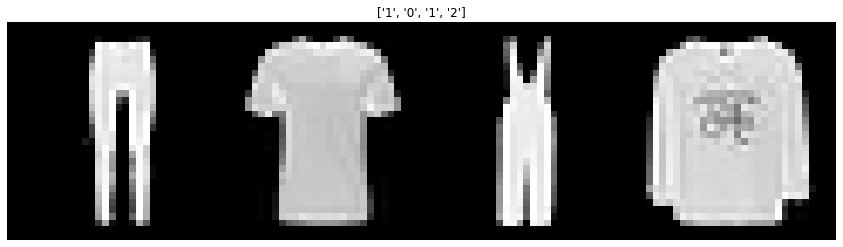

In [14]:
#코드 8-7	이미지	출력

images,	labels	=	show_batch_images(trainloader)

In [15]:
#코드 8-8	배치	정규화가	적용되지	않은	네트워크

class NormalNet(nn.Module):
				def __init__(self):
								super(NormalNet,	self).__init__()
								self.classifier	=	nn.Sequential(
												nn.Linear(784,	48),	#(28,	28)	크기의	이미지로	입력은	784(28×28) 크기가	됨
												nn.ReLU(),
												nn.Linear(48,	24),
												nn.ReLU(),
												nn.Linear(24,	10)	#FashionMNIST의	클래스는 총 열 개
								)	#	nn.Sequential을	사용하면 forward(	)	함수에서 계층(layer)별로	가독성 있게	코드 구현이 가능
				def forward(self,	x):
								x	=	x.view(x.size(0),	-1)
								x	=	self.classifier(x)	#	nn.Sequential에서	정의한 계층	호출
								return x

In [16]:
# 코드8-9	배치	정규화가	포함된	네트워크

class BNNet(nn.Module):
				def __init__(self):
								super(BNNet,	self).__init__()
								self.classifier	=	nn.Sequential(
												nn.Linear(784,	48),
												nn.BatchNorm1d(48),	#	①
												nn.ReLU(),
												nn.Linear(48,	24),
												nn.BatchNorm1d(24),
											nn.ReLU(),
												nn.Linear(24,	10)
								)
				def forward(self,	x):
								x	=	x.view(x.size(0),	-1)
								x	=	self.classifier(x)
								return	x


In [17]:
# 코드 8-10	배치	정규화가	적용되지	않은	모델	선언

model	=	NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [18]:
# 코드 8-11	배치	정규화가	적용된	모델	선언

model_bn	=	BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [19]:
#코드 8-12	데이터셋	메모리로	불러오기

batch_size	=	512
trainloader	=	torch.utils.data.DataLoader(trainset,	batch_size=batch_size,	shuffle=True)

In [20]:
#코드 8-13	옵티마이저,	손실	함수	지정

loss_fn	=	nn.CrossEntropyLoss()
opt	=	optim.SGD(model.parameters(),	lr=0.01)
opt_bn	=	optim.SGD(model_bn.parameters(),	lr=0.01)

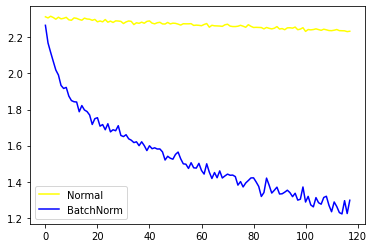

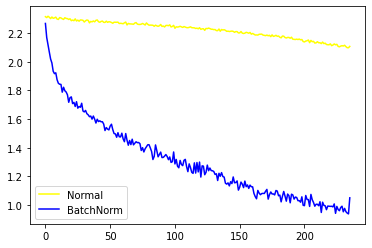

In [21]:
#PDF 847
#코드 8-14	모델	학습

loss_arr	=	[]
loss_bn_arr	=	[]
max_epochs	=	2
for epoch in range(max_epochs):
				for i,	data in enumerate(trainloader,	0):
								inputs,	labels	=	data
								opt.zero_grad()	#	배치	정규화가	적용되지	않은 모델의	학습
								outputs	=	model(inputs)
								loss	=	loss_fn(outputs,	labels)
								loss.backward()
								opt.step()
				
								opt_bn.zero_grad()	#	배치	정규화가	적용된	모델의	학습
								outputs_bn	=	model_bn(inputs)
								loss_bn	=	loss_fn(outputs_bn,	labels)
								loss_bn.backward()
								opt_bn.step()
				
								loss_arr.append(loss.item())
								loss_bn_arr.append(loss_bn.item())
				
				plt.plot(loss_arr,	'yellow',	label='Normal')
				plt.plot(loss_bn_arr,	'blue',	label='BatchNorm')
				plt.legend()
				plt.show()

In [22]:
#코드 8-15	데이터셋의	분포를	출력하기	위한	전처리

N	=	50
noise	=	0.3
x_train	=	torch.unsqueeze(torch.linspace(-1,	1,	N),	1)	#	①
y_train	=	x_train	+	noise	*	torch.normal(torch.zeros(N,	1),	torch.ones(N,	1))	#	②
x_test	=	torch.unsqueeze(torch.linspace(-1,	1,	N),	1)
y_test	=	x_test	+	noise	*	torch.normal(torch.zeros(N,	1), torch.ones(N,	1))

In [23]:
# torch.linspace는 다음과 같이 사용
#import	torch
#print(torch.linspace(0,	10))	------	0~10을	100으로	분할
#print('---------------')
#print(torch.linspace(0,	10,	5))	------	0~10을	5로	분할

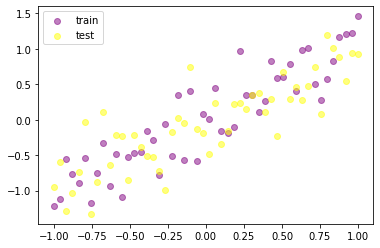

In [24]:
# 코드 8-16	데이터	분포를	그래프로	출력

plt.scatter(x_train.data.numpy(),	y_train.data.numpy(),	c='purple',	alpha=0.5,	label='train')	#	①
plt.scatter(x_test.data.numpy(),	y_test.data.numpy(),	c='yellow',	alpha=0.5,	label='test')
plt.legend()
plt.show()

In [25]:
#코드 8-17	드롭아웃을	위한	모델	생성

N_h	=	100
model	=	torch.nn.Sequential(
				torch.nn.Linear(1,	N_h),
				torch.nn.ReLU(),
				torch.nn.Linear(N_h,	N_h),
				torch.nn.ReLU(),
				torch.nn.Linear(N_h,	1),
)	#	드롭아웃이	적용되지	않은	모델

model_dropout	=	torch.nn.Sequential(
				torch.nn.Linear(1,	N_h),
				torch.nn.Dropout(0.2),	#	드롭아웃	적용
				torch.nn.ReLU(),
				torch.nn.Linear(N_h,	N_h),
				torch.nn.Dropout(0.2),
				torch.nn.ReLU(),
				torch.nn.Linear(N_h,	1),
)	#	드롭아웃이	적용된	모델

In [26]:
#코드 8-18	옵티마이저와	손실	함수	지정

opt	=	torch.optim.Adam(model.parameters(),	lr=0.01)
opt_dropout	=	torch.optim.Adam(model_dropout.parameters(),lr=0.01)
loss_fn	=	torch.nn.MSELoss()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


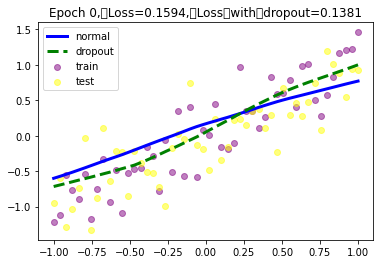

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


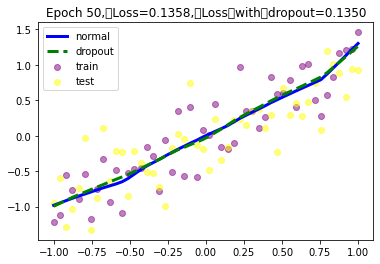

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


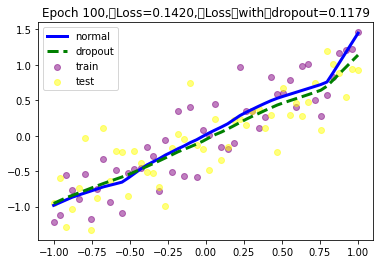

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


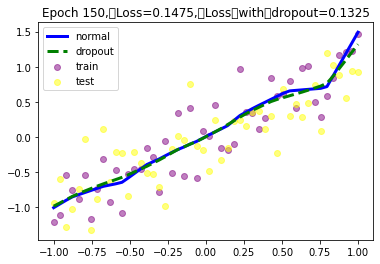

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


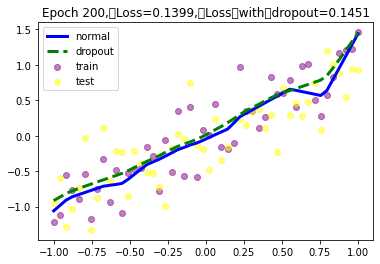

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


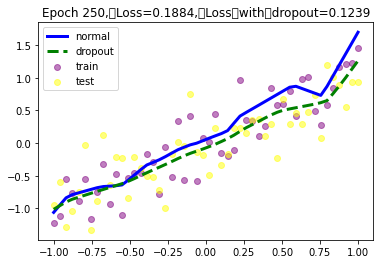

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


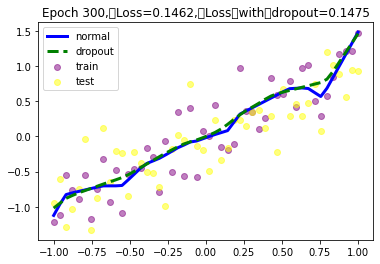

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


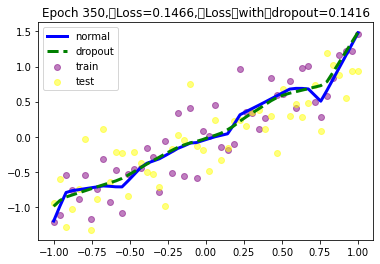

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


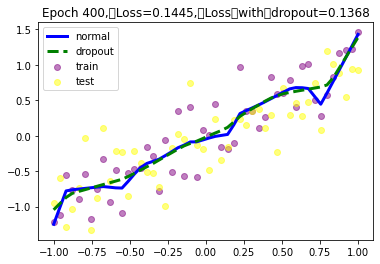

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


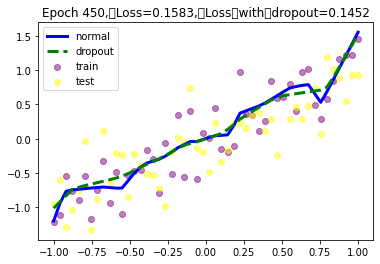

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


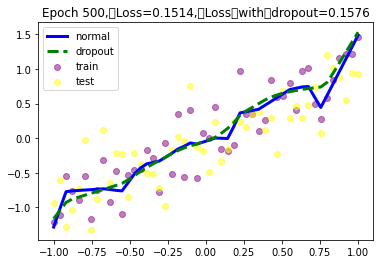

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


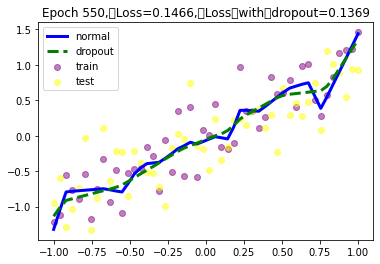

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


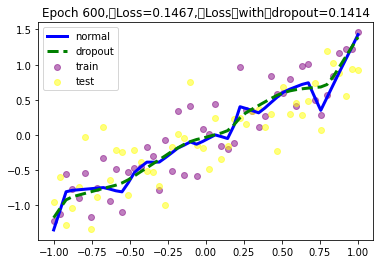

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


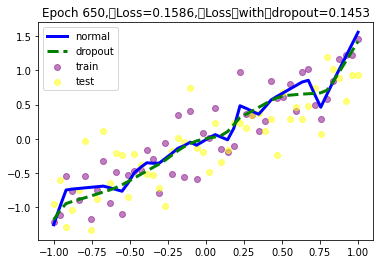

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


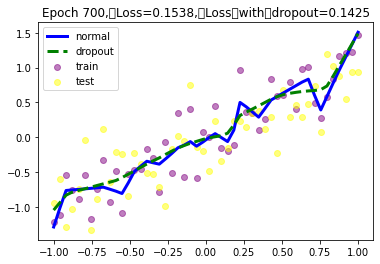

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


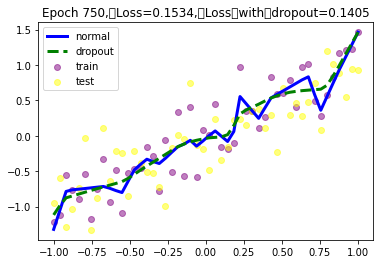

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


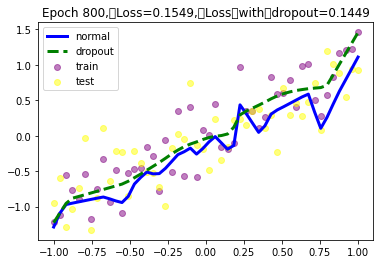

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


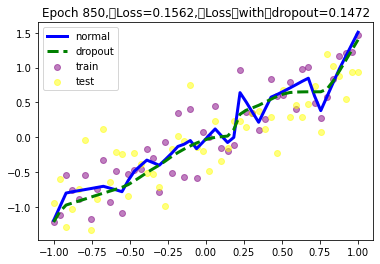

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


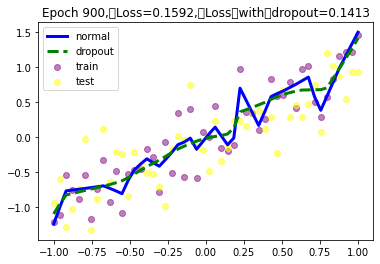

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


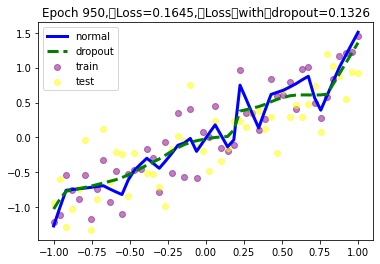

In [27]:
#코드 8-19	모델	학습
max_epochs	=	1000
for epoch in range(max_epochs):
    pred	=	model(x_train)	#	드롭아웃이	적용되지	않은모델	학습
    loss	=	loss_fn(pred,	y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
		
    pred_dropout	=	model_dropout(x_train)	#	드롭아웃이	적용된	모델	학습
    loss_dropout	=	loss_fn(pred_dropout,	y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
		
    if epoch	%	50	==	0:	#	epoch를	50으로	나눈	나머지가	0이면	다음	진행

        model.eval()
        model_dropout.eval()
				
        test_pred	=	model(x_test)
        test_loss	=	loss_fn(test_pred,	y_test)
				
        test_pred_dropout	=	model_dropout(x_test)
        test_loss_dropout	=	loss_fn(test_pred_dropout,	y_test)
				
        plt.scatter(x_train.data.numpy(),	y_train.data.numpy(),	c='purple',	alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow',	 alpha=0.5, label='test')		
						
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        #	파란색	실선으로	x축은	테스트	데이터셋,	y축은	드롭아웃이	적용되지	않은	모델의결과를	그래프로	출력
        plt.plot(x_test.data.numpy(),	test_pred_dropout.data.numpy(),	'g--',	lw=3,	label='dropout')	
				#	초록색	점선으로	x축은	테스트	데이터셋,	y축은	드롭아웃이	적용된	모델의	결과를	그래프로	출력
        plt.title('Epoch %d,	Loss=%0.4f,	Loss	with	dropout=%0.4f'	%	(epoch,	test_loss,	test_loss_dropout))	
				#	에포크,	드롭아웃이	적용되지	않은	모델의	오차,	드롭아웃이	적용된	모델의	오차를	타이틀로	출력

        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)

## 8.3.3 조기 종료를 이용한 성능 최적화

In [28]:
#코드8-20	라이브러리	호출

import	torch
import	torch.nn	as nn
import	torch.optim	as optim
import	torchvision.models as models #	사전	학습된	모델을	이용하고자	할	때	사용하는	라이브러리
from	torchvision	import	transforms,	datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')	#	출력	그래프에서	격자로	숫자	범위가	눈에	잘	띄도록	하는	스타일

device	=	torch.device("cuda:0" if	torch.cuda.is_available()	else "cpu")

In [29]:
# PDF 863
#코드 8-21	데이터셋	전처리

train_transform	=	transforms.Compose([
								transforms.Resize((224,	224)),
								transforms.RandomHorizontalFlip(),
								transforms.RandomVerticalFlip(),
								transforms.ToTensor(),
								transforms.Normalize(mean=[0.485,	0.456,	0.406],	std=[0.229,	0.224,	0.225])
				])
val_transform	=	transforms.Compose([
								transforms.Resize((224,	224)),
								transforms.ToTensor(),
								transforms.Normalize(mean=[0.485,	0.456,	0.406],	std=[0.229,	0.224,	0.225])
        ])

https://github.com/gilbutITbook/080289

<딥러닝 파이토치 교과서>(길벗, 2022) 도서의 예제 소스 파일입니다.
∙Jupyter Notebook과 Colab용 파일을 제공합니다.

∙실습에 필요한 데이터셋 대부분은 챕터별 data 폴더에 들어 있습니다.

=========================================
∙아래 설명을 꼭 읽어주세요!!!
∙대용량 데이터셋은 깃허브에 올라가지 않습니다. 따라서 아래의 안내에 따라 데이터를 내려받은 후 각 폴더에 넣어 사용합니다.

∙1) 10장 wiki.ko.vec만 별도로 내려받습니다.(약 2GB))
https://fasttext.cc/docs/en/pretrained-vectors.html 에서 Korea의 txt 파일

∙내려받은 wiki.ko.vec 파일은 10장의 data 폴더 > wiki.co 파일에 넣어서 사용합니다.

∙ 2) 아래 링크에서 glove.6b.100d.txt를 내려받습니다. 10장의 data 폴더에 넣어 실습하세요.

∙ 10장 glove.6B.100d.txt_내려받기
사이트 URL: https://nlp.stanford.edu/projects/glove/

∙데이터셋은 python과 colab 모두 동일하게 사용하며, 일부 압축 파일은 colab 실습용입니다.

∙8장부터는 colab에서 '런타임 유형'을 'GPU'로 설정하고 실습하는 것이 좋습니다. (실행 시간 단축)

=========================================
∙colab에 필요한 데이터는 파일을 업로드해서 사용해야 합니다. 두 가지 방식이 있는데, 책에서는 대부분 PC에서 파일을 업로드하는 방식으로 되어 있습니다.
구글 드라이브를 사용 중이라면 드라이브에 마운트해 사용하는 것이 좀 더 편리합니다. (부록을 참고하세요)

#PC에서 파일 업로드
from google.colab import files
file_uploaded=files.upload()

#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#부록은 PDF 1318페이지

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [31]:
ls

drive/  sample_data/


In [34]:
cd drive

/content/drive


In [35]:
ls

MyDrive/


In [36]:
train_dataset	=	datasets.ImageFolder(
				root=r'../chap08/data/archive/train',
				transform=train_transform
)
train_dataloader	=	torch.utils.data.DataLoader(
				train_dataset,	batch_size=32,	shuffle=True,
)
val_dataset	=	datasets.ImageFolder(
				root=r'../chap08/data/archive/test',
				transform=val_transform
)
val_dataloader	=	torch.utils.data.DataLoader(
				val_dataset,	batch_size=32,	shuffle=False,
)

FileNotFoundError: ignored

In [57]:
#PDF 865
#코드 8-22	데이터셋	가져오기

#train_dataset	=	datasets.ImageFolder(root = r'../chap08/data/archive/train', transform = train_transform)
#/content/drive/MyDrive/Colab Notebooks/chab08/train

train_dataset	=	datasets.ImageFolder(root = r'/content/drive/MyDrive/Colab Notebooks/chab08/train', transform = train_transform)

train_dataloader	=	torch.utils.data.DataLoader(
				train_dataset,	batch_size=32,	shuffle=True,
)

val_dataset	=	datasets.ImageFolder(
				root=r'/content/drive/MyDrive/Colab Notebooks/chab08/test',
				transform=val_transform
)

val_dataloader	=	torch.utils.data.DataLoader(
				val_dataset,	batch_size=32,	shuffle=False,
)

In [40]:
#모델 생성, 네트워크를 직접 구축하는 것이 아닌 사전 학습된 ResNet50을 사용
#6장에서 배웠듯이 사전 학습된 모델을 사용할 경우 간편하게 네트워크를 구성하고 사용할 수 있는 장점이 있음

#코드 8-23	모델	생성

def resnet50(pretrained=True,	requires_grad=False):
				model	=	models.resnet50(progress=True,	pretrained=pretrained)
				if requires_grad	==	False: #파라미터를	고정하여 backward()	중에	기울기가	계산되지	않도록	함
                                     #requires _grad=False를	파라미터로	받았기	때문에	해당	구문이	실행됨
								for param in model.parameters():
												param.requires_grad	=	False
				elif	requires_grad	==	True:	#파라미터	값이	backward()	중에	기울기	계산에	반영됩니다.
								for param in	model.parameters():
												param.requires_grad	=	True
				model.fc	=	nn.Linear(2048,	2) #마지막	분류를	위한	계층은	학습을	진행합니다.
				return	model


In [41]:
# 코드 8-24	학습률	감소

class LRScheduler():
				def __init__(
								self,	optimizer,	patience=5,	min_lr=1e-6,	factor=0.5
				):
								self.optimizer	=	optimizer
								self.patience	=	patience
								self.min_lr	=	min_lr
								self.factor	=	factor
								self.lr_scheduler	=	torch.optim.lr_scheduler.ReduceLROnPlateau(
												self.optimizer,
												mode='min',
												patience=self.patience,
												factor=self.factor,
												min_lr=self.min_lr,
												verbose=True
								)	#	①
                
				def __call__(self,	val_loss):
								self.lr_scheduler.step(val_loss)	#	②


In [42]:
# 코드 8-25	조기	종료

class EarlyStopping():
    def __init__(self,	patience=5,	verbose=False,	delta=0,path='../chap08/data/checkpoint.pt'):
        self.patience	=	patience #	①
        self.verbose	=	verbose
        self.counter	=	0
        self.best_score	=	None #	검증	데이터셋에	대한오차	최적화	값(오차가	가장	낮은	값)
        self.early_stop	=	False #	조기	종료를	의미하며	초깃값은	False로	설정
        self.val_loss_min	=	np.Inf	#	np.Inf(infinity)는	넘파이에서	무한대를	표현
        self.delta	=	delta #	②
        self.path	=	path #	모델이	저장될	경로

    def __call__(self,	val_loss,	model):	#	에포크만큼학습이	반복되면서	best_loss가	갱신되고,	best_loss에	진전이없으면	조기	종료한	후	모델을	저장
        score	=	-val_loss
        if self.best_score	is None:	#	best_score에	값이	존재하지	않으면	실행
												self.best_score	=	score
												self.save_checkpoint(val_loss,	model)
        elif	score	<	self.best_score	+	self.delta:	#best_score	+	delta가	score보다	크면	실행
												self.counter	+=	1
												print(f'EarlyStopping	counter: {self.counter}out	of {self.patience}')
												if self.counter	>=	self.patience:
																self.early_stop	=	True
        else:	#	그	외	모든	경우에	실행
												self.best_score	=	score
												self.save_checkpoint(val_loss,	model)
												self.counter	=	0

    def save_checkpoint(self,	val_loss,	model):	#	검증	데이터셋에	대한	오차가	감소하면	모델을	저장
        if self.verbose:
            print(f'Validation	loss	decreased	({self.val_loss_min:.6f} --> {val_loss:.6f}).	Saving	model	...')
        torch.save(model.state_dict(),	self.path)	#지정된	경로에	모델	저장
        self.val_loss_min	=	val_loss


In [43]:
# 코드 8-26	인수	값	지정
#오류뜸 #아래 셀로

parser =	argparse.ArgumentParser()	#	인수	값을	받을수	있는	인스턴스	생성
parser.add_argument('--lr-scheduler',	dest='lr_scheduler', action='store_true')	#	①
parser.add_argument('--early-stopping',	dest= 'early_stopping',	action='store_true')	#	조기	종료에	대한	인수
args =	vars(parser.parse_args())	#	②

usage: ipykernel_launcher.py [-h] [--lr-scheduler] [--early-stopping]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-d8e0c1d3-2194-497e-a591-17be2be9c59a.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [58]:
#자료실 코드 (위에까지는 다 책 복붙)
#https://github.com/gilbutITbook/080289/blob/main/chap08/es-python_8%EC%9E%A5.ipynb

parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')


#이 코드가 추가됨
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다

args = vars(parser.parse_args())

In [45]:
#코드 8-27	사전	훈련된	모델의	파라미터	확인

print(f"Computation	device: {device}\n")	#	CPU를	사용하는지	GPU를	사용하는지	검사
model	=	models.resnet50(pretrained=True).to(device)	#사전	훈련된	ResNet50	사용
total_params	=	sum(p.numel() for p in model.parameters()) #	총	파라미터	수
print(f"{total_params:,}	total	parameters.")
total_trainable_params	=	sum(
				p.numel()	for p in model.parameters()	if p.requires_grad)	#	학습	가능한	파라미터	수
print(f"{total_trainable_params:,}	training	parameters.")

Computation	device: cuda:0



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

25,557,032	total	parameters.
25,557,032	training	parameters.


In [46]:
# 코드 8-28	옵티마이저와	손실	함수	지정

lr	=	0.001
epochs	=	100
optimizer	=	optim.Adam(model.parameters(),	lr=lr)
criterion	=	nn.CrossEntropyLoss()

In [47]:
#코드 8-29	오차,	정확도	및	모델의	이름에	대한	문자열

loss_plot_name	=	'loss' #	오차	출력에	대한	문자열
acc_plot_name	=	'accuracy' #	정확도	출력에	대한	문자열
model_name	=	'model' #	모델을	저장하기	위한	문자열

In [48]:
#코드 8-30	오차,	정확도	및	모델의	이름에	대한	문자열

if	args['lr_scheduler']:
				print('INFO:	Initializing	learning	rate	scheduler')
				lr_scheduler	=	LRScheduler(optimizer)
				loss_plot_name	=	'lrs_loss' #	학습률	감소를	적용했을	때의	오차에	대한	문자열
				acc_plot_name	=	'lrs_accuracy' #	학습률	감소를	적용했을	때의	정확도에	대한	문자열
				model_name	=	'lrs_model' #	학습률	감소를	적용했을때의	모델에	대한	문자열

if	args['early_stopping']:
				print('INFO:	Initializing	early	stopping')
				early_stopping	=	EarlyStopping()
				loss_plot_name	=	'es_loss' #	조기	종료를	적용했을때의	오차에	대한	문자열
				acc_plot_name	=	'es_accuracy' #	조기	종료를	적용했을	때의	정확도에	대한	문자열
				model_name	=	'es_model' #	조기	종료를	적용했을	때의	모델에	대한	문자열

In [49]:
#코드 8-31	모델	학습	함수

def training(model,	train_dataloader,	train_dataset,	optimizer,	criterion):
				print('Training')
				model.train()
				train_running_loss	=	0.0
				train_running_correct	=	0
				counter	=	0
				total	=	0
				prog_bar	=	tqdm(enumerate(train_dataloader),	total=int(len(train_dataset)/train_dataloader.batch_size))	#훈련	진행	과정을	시각적으로	표현
				for i,	data in prog_bar:
								counter	+=	1
								data,	target	=	data[0].to(device),	data[1].to(device)
								total	+=	target.size(0)
								optimizer.zero_grad()
								outputs	=	model(data)
								loss	=	criterion(outputs,	target)
								train_running_loss	+=	loss.item()
								_,	preds	=	torch.max(outputs.data,	1)
								train_running_correct	+=	(preds	==	target).sum().item()
								loss.backward()
								optimizer.step()
				train_loss	=	train_running_loss	/	counter
				train_accuracy	=	100.	*	train_running_correct	/	total
				return train_loss,	train_accuracy


In [50]:
#코드 8-32	모델	검증	함수

def validate(model,	test_dataloader,	val_dataset,	criterion):
    print('Validating')
    model.eval()
    val_running_loss	=	0.0
    val_running_correct	=	0
    counter	=	0
    total	=	0
    prog_bar	=	tqdm(enumerate(test_dataloader),	total=int(len(val_dataset)/test_dataloader.batch_size))	#	모델검증	과정을	시각적으로	표현
    with	torch.no_grad():
        for i,	data in prog_bar:
            counter	+=	1
            data,	target	=	data[0].to(device), data[1].to(device)
            total	+=	target.size(0)
            outputs	=	model(data)
            loss	=	criterion(outputs,	target)
            val_running_loss	+=	loss.item()
            _,	preds	=	torch.max(outputs.data,	1)
            val_running_correct	+=	(preds	==	target).sum().item()
            val_loss	=	val_running_loss	/	counter
            val_accuracy	=	100.	*	val_running_correct	/	total
            return val_loss,	val_accuracy

In [52]:
#코드 8-33	모델	학습

train_loss,	train_accuracy	=	[],	[] #훈련 데이터셋을 이용한 모델	학습 결과(오차, 정확도)를	저장하기 위한	변수(리스트	형태)
val_loss,	val_accuracy	=	[],	[]	#검증	데이터셋을	이용한	모델	성능	결과(오차,	정확도)를	저장하기	위한	변수(리스트	형태)
start	=	time.time()
for epoch in range(epochs):
    print(f"Epoch	{epoch+1}	of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss,	val_epoch_accuracy	=	validate(
								model,	val_dataloader,	val_dataset,	criterion
				)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
		
    if	args['lr_scheduler']:	#	인수	값이 lr_scheduler이면	다음을	실행
        lr_scheduler(val_epoch_loss)
    if	args['early_stopping']:	#	인수	값이	early_stopping이면	다음을	실행
        early_stopping(val_epoch_loss,	model)
        if	early_stopping.early_stop:
            break

    print(f"Train	Loss: {train_epoch_loss:.4f},	Train	Acc:{train_epoch_accuracy:.2f}")
    print(f'Val	Loss: {val_epoch_loss:.4f},	Val	Acc: {val_epoch_accuracy:.2f}')
		
end	=	time.time()
print(f"Training	time:	{(end-start)/60:.3f}	minutes")

Epoch	1	of 100
Training


16it [02:41, 10.09s/it]


Validating


  0%|          | 0/15 [00:23<?, ?it/s]


Train	Loss: 1.1559,	Train	Acc:67.87
Val	Loss: 0.0039,	Val	Acc: 100.00
Epoch	2	of 100
Training


16it [00:08,  1.92it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.4656,	Train	Acc:78.51
Val	Loss: 0.8843,	Val	Acc: 59.38
Epoch	3	of 100
Training


16it [00:08,  1.93it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.4244,	Train	Acc:81.73
Val	Loss: 0.3669,	Val	Acc: 81.25
Epoch	4	of 100
Training


16it [00:08,  1.94it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.3529,	Train	Acc:82.73
Val	Loss: 0.9289,	Val	Acc: 81.25
Epoch	5	of 100
Training


16it [00:08,  1.94it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.3593,	Train	Acc:86.95
Val	Loss: 0.7427,	Val	Acc: 62.50
Epoch	6	of 100
Training


16it [00:08,  1.93it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2820,	Train	Acc:86.75
Val	Loss: 0.6066,	Val	Acc: 68.75
Epoch	7	of 100
Training


16it [00:08,  1.93it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2032,	Train	Acc:91.77
Val	Loss: 0.5148,	Val	Acc: 71.88
Epoch	8	of 100
Training


16it [00:08,  1.93it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1871,	Train	Acc:90.96
Val	Loss: 0.1747,	Val	Acc: 93.75
Epoch	9	of 100
Training


16it [00:08,  1.82it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2141,	Train	Acc:90.36
Val	Loss: 1.4644,	Val	Acc: 65.62
Epoch	10	of 100
Training


16it [00:08,  1.92it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2421,	Train	Acc:89.76
Val	Loss: 0.3564,	Val	Acc: 84.38
Epoch	11	of 100
Training


16it [00:08,  1.92it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1512,	Train	Acc:92.37
Val	Loss: 0.4800,	Val	Acc: 87.50
Epoch	12	of 100
Training


16it [00:08,  1.92it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1412,	Train	Acc:93.57
Val	Loss: 1.6751,	Val	Acc: 65.62
Epoch	13	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2109,	Train	Acc:90.36
Val	Loss: 0.5061,	Val	Acc: 78.12
Epoch	14	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2668,	Train	Acc:89.56
Val	Loss: 0.4077,	Val	Acc: 81.25
Epoch	15	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.2694,	Train	Acc:91.16
Val	Loss: 1.6932,	Val	Acc: 40.62
Epoch	16	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1824,	Train	Acc:93.57
Val	Loss: 0.9067,	Val	Acc: 81.25
Epoch	17	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1437,	Train	Acc:95.38
Val	Loss: 0.6180,	Val	Acc: 87.50
Epoch	18	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1279,	Train	Acc:94.78
Val	Loss: 1.7840,	Val	Acc: 53.12
Epoch	19	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1148,	Train	Acc:96.79
Val	Loss: 2.0966,	Val	Acc: 50.00
Epoch	20	of 100
Training


16it [00:08,  1.87it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0804,	Train	Acc:96.59
Val	Loss: 0.8066,	Val	Acc: 84.38
Epoch	21	of 100
Training


16it [00:08,  1.84it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1569,	Train	Acc:94.38
Val	Loss: 0.9645,	Val	Acc: 81.25
Epoch	22	of 100
Training


16it [00:08,  1.92it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0946,	Train	Acc:96.99
Val	Loss: 0.3792,	Val	Acc: 84.38
Epoch	23	of 100
Training


16it [00:08,  1.91it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0600,	Train	Acc:97.99
Val	Loss: 0.4971,	Val	Acc: 84.38
Epoch	24	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0883,	Train	Acc:97.39
Val	Loss: 2.2017,	Val	Acc: 56.25
Epoch	25	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1044,	Train	Acc:96.18
Val	Loss: 1.4388,	Val	Acc: 65.62
Epoch	26	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0717,	Train	Acc:97.59
Val	Loss: 1.3772,	Val	Acc: 65.62
Epoch	27	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1425,	Train	Acc:94.58
Val	Loss: 0.6298,	Val	Acc: 78.12
Epoch	28	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0731,	Train	Acc:97.39
Val	Loss: 0.5377,	Val	Acc: 81.25
Epoch	29	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0744,	Train	Acc:97.59
Val	Loss: 1.3170,	Val	Acc: 65.62
Epoch	30	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1061,	Train	Acc:95.18
Val	Loss: 1.0535,	Val	Acc: 78.12
Epoch	31	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1170,	Train	Acc:95.58
Val	Loss: 1.9817,	Val	Acc: 53.12
Epoch	32	of 100
Training


16it [00:08,  1.78it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1224,	Train	Acc:95.18
Val	Loss: 0.7262,	Val	Acc: 78.12
Epoch	33	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1093,	Train	Acc:96.18
Val	Loss: 2.0799,	Val	Acc: 56.25
Epoch	34	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1002,	Train	Acc:96.79
Val	Loss: 1.0138,	Val	Acc: 75.00
Epoch	35	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1076,	Train	Acc:95.78
Val	Loss: 0.7613,	Val	Acc: 71.88
Epoch	36	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0466,	Train	Acc:98.59
Val	Loss: 0.5839,	Val	Acc: 84.38
Epoch	37	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0549,	Train	Acc:97.79
Val	Loss: 0.7047,	Val	Acc: 81.25
Epoch	38	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0361,	Train	Acc:99.00
Val	Loss: 1.5486,	Val	Acc: 62.50
Epoch	39	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0236,	Train	Acc:99.00
Val	Loss: 1.2219,	Val	Acc: 78.12
Epoch	40	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0469,	Train	Acc:98.39
Val	Loss: 1.6289,	Val	Acc: 62.50
Epoch	41	of 100
Training


16it [00:08,  1.84it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0687,	Train	Acc:97.59
Val	Loss: 1.0361,	Val	Acc: 75.00
Epoch	42	of 100
Training


16it [00:08,  1.86it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0691,	Train	Acc:96.39
Val	Loss: 0.6777,	Val	Acc: 84.38
Epoch	43	of 100
Training


16it [00:08,  1.87it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0687,	Train	Acc:97.59
Val	Loss: 3.7856,	Val	Acc: 40.62
Epoch	44	of 100
Training


16it [00:09,  1.75it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0886,	Train	Acc:96.99
Val	Loss: 0.8389,	Val	Acc: 87.50
Epoch	45	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1006,	Train	Acc:96.39
Val	Loss: 1.0064,	Val	Acc: 78.12
Epoch	46	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0980,	Train	Acc:96.39
Val	Loss: 1.4823,	Val	Acc: 68.75
Epoch	47	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1136,	Train	Acc:95.98
Val	Loss: 1.7779,	Val	Acc: 53.12
Epoch	48	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0947,	Train	Acc:96.59
Val	Loss: 0.7213,	Val	Acc: 78.12
Epoch	49	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1291,	Train	Acc:95.18
Val	Loss: 0.5396,	Val	Acc: 81.25
Epoch	50	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1023,	Train	Acc:96.79
Val	Loss: 2.0624,	Val	Acc: 65.62
Epoch	51	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0507,	Train	Acc:98.19
Val	Loss: 1.1818,	Val	Acc: 78.12
Epoch	52	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0422,	Train	Acc:98.59
Val	Loss: 1.4701,	Val	Acc: 65.62
Epoch	53	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0633,	Train	Acc:98.19
Val	Loss: 0.6014,	Val	Acc: 78.12
Epoch	54	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0408,	Train	Acc:98.59
Val	Loss: 0.4458,	Val	Acc: 78.12
Epoch	55	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0263,	Train	Acc:99.00
Val	Loss: 0.7505,	Val	Acc: 75.00
Epoch	56	of 100
Training


16it [00:08,  1.78it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0472,	Train	Acc:97.79
Val	Loss: 0.8341,	Val	Acc: 78.12
Epoch	57	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0583,	Train	Acc:98.19
Val	Loss: 1.6138,	Val	Acc: 71.88
Epoch	58	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0757,	Train	Acc:97.19
Val	Loss: 0.7890,	Val	Acc: 81.25
Epoch	59	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0642,	Train	Acc:98.19
Val	Loss: 0.9259,	Val	Acc: 75.00
Epoch	60	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1652,	Train	Acc:93.37
Val	Loss: 0.1580,	Val	Acc: 93.75
Epoch	61	of 100
Training


16it [00:08,  1.87it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0956,	Train	Acc:96.79
Val	Loss: 1.0456,	Val	Acc: 78.12
Epoch	62	of 100
Training


16it [00:08,  1.85it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0933,	Train	Acc:97.19
Val	Loss: 1.5296,	Val	Acc: 68.75
Epoch	63	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0462,	Train	Acc:98.19
Val	Loss: 1.5392,	Val	Acc: 75.00
Epoch	64	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0623,	Train	Acc:96.59
Val	Loss: 0.8827,	Val	Acc: 71.88
Epoch	65	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0219,	Train	Acc:99.20
Val	Loss: 1.5713,	Val	Acc: 62.50
Epoch	66	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0389,	Train	Acc:98.59
Val	Loss: 1.2246,	Val	Acc: 78.12
Epoch	67	of 100
Training


16it [00:08,  1.78it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0390,	Train	Acc:98.80
Val	Loss: 0.3122,	Val	Acc: 84.38
Epoch	68	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0445,	Train	Acc:98.39
Val	Loss: 1.7757,	Val	Acc: 53.12
Epoch	69	of 100
Training


16it [00:08,  1.87it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0276,	Train	Acc:99.20
Val	Loss: 1.0914,	Val	Acc: 59.38
Epoch	70	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0349,	Train	Acc:98.39
Val	Loss: 5.2224,	Val	Acc: 43.75
Epoch	71	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0540,	Train	Acc:97.79
Val	Loss: 1.2852,	Val	Acc: 75.00
Epoch	72	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0426,	Train	Acc:98.80
Val	Loss: 1.8867,	Val	Acc: 62.50
Epoch	73	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0566,	Train	Acc:97.99
Val	Loss: 1.0883,	Val	Acc: 71.88
Epoch	74	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0597,	Train	Acc:97.99
Val	Loss: 1.0901,	Val	Acc: 81.25
Epoch	75	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0559,	Train	Acc:97.99
Val	Loss: 0.5580,	Val	Acc: 90.62
Epoch	76	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0271,	Train	Acc:99.20
Val	Loss: 1.1750,	Val	Acc: 75.00
Epoch	77	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0535,	Train	Acc:98.39
Val	Loss: 1.6074,	Val	Acc: 65.62
Epoch	78	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.1316,	Train	Acc:96.39
Val	Loss: 3.9203,	Val	Acc: 53.12
Epoch	79	of 100
Training


16it [00:09,  1.78it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0860,	Train	Acc:97.39
Val	Loss: 1.0078,	Val	Acc: 81.25
Epoch	80	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0971,	Train	Acc:97.39
Val	Loss: 1.1071,	Val	Acc: 62.50
Epoch	81	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0844,	Train	Acc:97.19
Val	Loss: 0.3626,	Val	Acc: 84.38
Epoch	82	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0455,	Train	Acc:98.39
Val	Loss: 0.6735,	Val	Acc: 81.25
Epoch	83	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0267,	Train	Acc:99.40
Val	Loss: 1.1575,	Val	Acc: 68.75
Epoch	84	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0460,	Train	Acc:97.99
Val	Loss: 0.8623,	Val	Acc: 78.12
Epoch	85	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0293,	Train	Acc:99.20
Val	Loss: 0.7340,	Val	Acc: 84.38
Epoch	86	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0327,	Train	Acc:98.59
Val	Loss: 1.5516,	Val	Acc: 71.88
Epoch	87	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0668,	Train	Acc:97.99
Val	Loss: 1.2506,	Val	Acc: 75.00
Epoch	88	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0628,	Train	Acc:97.79
Val	Loss: 0.2333,	Val	Acc: 93.75
Epoch	89	of 100
Training


16it [00:08,  1.88it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0745,	Train	Acc:97.59
Val	Loss: 1.4118,	Val	Acc: 68.75
Epoch	90	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0523,	Train	Acc:97.99
Val	Loss: 1.6233,	Val	Acc: 65.62
Epoch	91	of 100
Training


16it [00:08,  1.78it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0417,	Train	Acc:98.39
Val	Loss: 0.8076,	Val	Acc: 81.25
Epoch	92	of 100
Training


16it [00:08,  1.90it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0300,	Train	Acc:98.80
Val	Loss: 1.4359,	Val	Acc: 78.12
Epoch	93	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0166,	Train	Acc:99.40
Val	Loss: 1.2856,	Val	Acc: 78.12
Epoch	94	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0194,	Train	Acc:99.20
Val	Loss: 1.1288,	Val	Acc: 78.12
Epoch	95	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0336,	Train	Acc:98.39
Val	Loss: 1.2281,	Val	Acc: 71.88
Epoch	96	of 100
Training


16it [00:08,  1.85it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0515,	Train	Acc:98.19
Val	Loss: 2.8824,	Val	Acc: 56.25
Epoch	97	of 100
Training


16it [00:08,  1.86it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0258,	Train	Acc:98.80
Val	Loss: 0.6061,	Val	Acc: 75.00
Epoch	98	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0205,	Train	Acc:99.40
Val	Loss: 0.4496,	Val	Acc: 81.25
Epoch	99	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]


Train	Loss: 0.0165,	Train	Acc:99.60
Val	Loss: 1.4827,	Val	Acc: 78.12
Epoch	100	of 100
Training


16it [00:08,  1.89it/s]


Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train	Loss: 0.0073,	Train	Acc:100.00
Val	Loss: 1.5941,	Val	Acc: 71.88
Training	time:	17.662	minutes


Saving	loss	and	accuracy	plots...


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


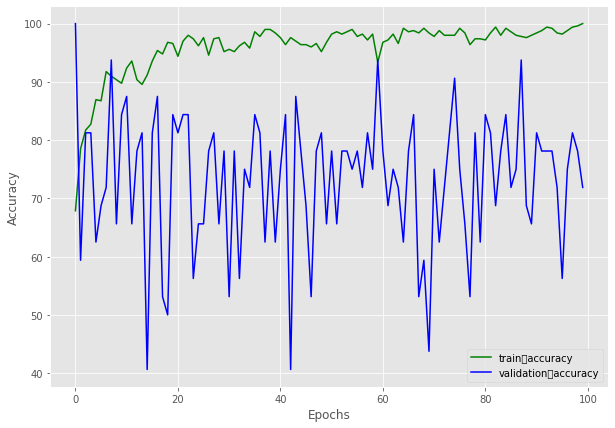

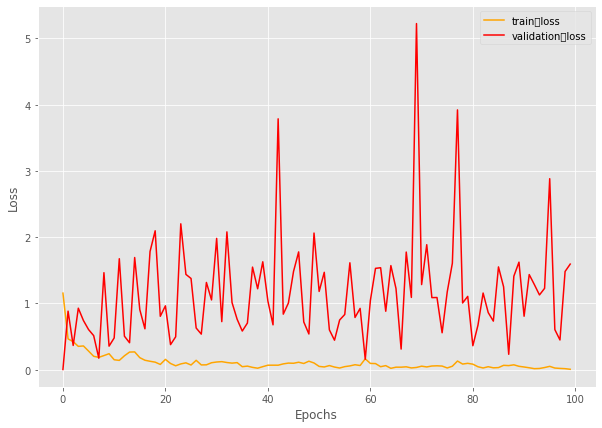

Saving	model...
TRAINING	COMPLETE


In [55]:
# 코드 8-34	모델 학습 결과 출력

print('Saving	loss	and	accuracy	plots...')
plt.figure(figsize=(10,	7))
plt.plot(train_accuracy, color='green',	label='train	accuracy')	#	훈련	데이터셋에	대한 오차를	그래프로	출력
plt.plot(val_accuracy,	color='blue',	label='validation	accuracy')	#	검증 데이터셋에 대한 정확도를	그래프로	출력		
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/chab08/img/{acc_plot_name}.png")
plt.show()
plt.figure(figsize=(10,	7))
plt.plot(train_loss,	color='orange',	label='train	loss')	#훈련	데이터셋에	대한	정확도를	그래프로	출력
plt.plot(val_loss,	color='red',	label='validation	loss')	#검증	데이터셋에	대한	오차를	그래프로	출력
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/chab08/img/{loss_plot_name}.png")
plt.show()
print('Saving	model...')
torch.save(model.state_dict(),	f"/content/drive/MyDrive/Colab Notebooks/chab08/img/{model_name}.pth")	#	모델을 저장
print('TRAINING	COMPLETE')
